<a href="https://colab.research.google.com/github/amanda-araujo/redes-neurais-aprendizado-profundo/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [ ]:
# AUTOENCODER

# Libraries and packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Autoencoder architecture
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8, 16,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3,
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

# Initialize the autoencoder
model = Autoencoder()

# Define transform (x): ToTensor()
'''Flowers102: unequal tensor sizes; stack expects each tensor to be equal size, but got [3, 620, 500] at entry 0 and [3, 500, 752] at entry 1'''
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load dataset
'''MNIST'''
training_data = MNIST( #60.000 samples for training and 10.000 for testing.
    root="data",       #root: caminho onde os dados serão armazenados localmente
    train=True,        #train: variável binária dados de treinamento (True) e teste (False)
    download=True,     #download: se True faz download da Internet caso os dados não estejam disponíveis localmente
    transform=ToTensor() #transform e target_transform especifica transformações para as features e labels.
)

testing_data = MNIST(
    root="data",
    train=False,        #train: treinamento (True) e teste (False)
    download=True,
    transform=ToTensor()
)

'''Flowers102'''
train_dataset2 = datasets.Flowers102(root='flowers',
                                    split='train',
                                    transform=transform,
                                    download=True)
test_dataset2 = datasets.Flowers102(root='flowers',
                                   split='test',
                                   transform=transform)

print("MNIST format:", training_data[0][0].shape, "Class of the first example:", training_data[0][1])
print("Flowers102 format:", train_dataset2[0][0].shape, "Class of the first example:", train_dataset2[0][1])
#500*764=382000

# Define dataloader
batch_size = 128
'''MNIST'''
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=batch_size)
'''Flowers102'''
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset2,
                                          batch_size=batch_size)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  #mean squared error between each element in the input x and target y
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 50

'''Flowers102: 3m55s'''
print("Flowers102:")
for epoch in range(num_epochs):
    for data in train_loader2:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

'''MNIST'''
print("MNIST")
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

MNIST format: torch.Size([1, 28, 28]) Class of the first example: 5
Flowers102 format: torch.Size([3, 64, 64]) Class of the first example: 0
cuda
Flowers102:
Epoch [1/50], Loss: 0.0832
Epoch [6/50], Loss: 0.0782
Epoch [11/50], Loss: 0.0375
Epoch [16/50], Loss: 0.0236
Epoch [21/50], Loss: 0.0173
Epoch [26/50], Loss: 0.0152
Epoch [31/50], Loss: 0.0125
Epoch [36/50], Loss: 0.0124
Epoch [41/50], Loss: 0.0118
Epoch [46/50], Loss: 0.0119
MNIST


RuntimeError: ignored

> Para o conjunto de dados Flowers102, o autoencoder funciona perfeitamente, e a função de perda (loss) diminui conforme passam as *epocs*. Problemas com MNIST... investigando formatos:

In [ ]:
# Shape image dataset

'''MNIST'''
print("MNIST--------")

dataiter = iter(test_loader)
imgs, _ = next(dataiter)

# Lets se the shape of 1 image
img = imgs[1]
print("Image shape:", img.shape, '\n')

'''Flowers102'''
print("Flowers102---------")
dataiter = iter(test_loader2)
imgs, _ = next(dataiter)

# Lets se the shape of 1 image
img = imgs[1]
print("Image shape:", img.shape, '\n')

MNIST--------
Image shape: torch.Size([1, 28, 28]) 

Flowers102---------
Image shape: torch.Size([3, 64, 64]) 



A arquitetura do autoencoder é alterada dependendo do tamanho da imagem (input). Nesse caso, Flowers102 tem formato [3, 64, 64] - 3 canais, enquanto MNIST apresenta [1, 28, 28] - apenas 1 canal. Ao tentar aplicar o autoencoder tendo como entrada uma imagem de MNIST obtém se erro:
  
  > "Given groups=1, weight of size [16, 3, 3, 3], expected input[128, 1, 28, 28] to have 3 channels, but got 1 channels instead"




Ou seja, o autoenconder deve ser construído tendo em mente o formato dos dados que a rede receberá e terá de lidar com. O tamanho de entrada da primeira camada da rede (in_channel) deve estar de acordo com o tamanho da imagem do conjunto de dados a ser passado. No caso, aparaentemente in_channels = #número de canais do input.

# Autoencoder: T2 (MNIST)

## Building and Training the Autoencoder

In [2]:
# Libraries and packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [3]:
# Autoencoder architecture T2
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), #in_channels, out_channels= #filters
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    )

    # flatten: tensor to vector (conv to linear)
    self.linear_encoder = nn.Sequential(
        nn.Linear(64*7*7, 128),
        nn.ReLU()
    )

    self.linear_decoder = nn.Sequential(
        nn.Linear(128, 64*7*7),
        nn.ReLU()
    )

    # (non)flatten: vector to tensor (linear to conv)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32,
                               kernel_size=2,
                               stride=2),
                               #padding=1,
                               #output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1,
                            kernel_size=2,
                            stride=2),
                            #padding=1,
                            #output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # print("shape initial:")
    # print(x.shape)

    x = self.encoder(x)
    # print("shape after encoder (conv):")
    # print(x.shape)

    # for flattening (to allow use linear layers) we need to change the dimension to a vector
    x = x.view(x.size(0), -1)
    # print("shape after flattening:")
    # print(x.shape)

    x = self.linear_encoder(x)
    # print("shape after encoder (linear):")
    # print(x.shape)

    x = self.linear_decoder(x)
    # print("shape after decoder (linear):")
    # print(x.shape)

    # for the inverse (linear to conv; vector to tensor)
    x = x.view(x.size(0), 64, 7, 7) #64*7*7
    # print("shape after inverse flattening (vector to tensor):")
    # print(x.shape)

    x = self.decoder(x)
    # print("shape after decoder (conv):")
    # print(x.shape)
    return x

In [ ]:
# Initialize the autoencoder
model = Autoencoder()

In [4]:
# Load dataset
'''MNIST'''
training_data = MNIST( #60.000 samples for training and 10.000 for testing.
    root="data",       #root: caminho onde os dados serão armazenados localmente
    train=True,        #train: variável binária dados de treinamento (True) e teste (False)
    download=True,     #download: se True faz download da Internet caso os dados não estejam disponíveis localmente
    transform=ToTensor() #transform e target_transform especifica transformações para as features e labels.
)

testing_data = MNIST(
    root="data",
    train=False,        #train: treinamento (True) e teste (False)
    download=True,
    transform=ToTensor()
)
print("MNIST format:", training_data[0][0].shape, "Class of the first example:", training_data[0][1])

# Define dataloader
batch_size = 128
'''MNIST'''
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 100114407.18it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75146212.05it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27168767.98it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5063936.41it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

MNIST format: torch.Size([1, 28, 28]) Class of the first example: 5


In [5]:
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cpu


NameError: ignored

MNIST
Epoch [1/40], Loss: 0.1011
Epoch [6/40], Loss: 0.0741
Epoch [11/40], Loss: 0.0758
Epoch [16/40], Loss: 0.0728
Epoch [21/40], Loss: 0.0713
Epoch [26/40], Loss: 0.0696
Epoch [31/40], Loss: 0.0675
Epoch [36/40], Loss: 0.0702


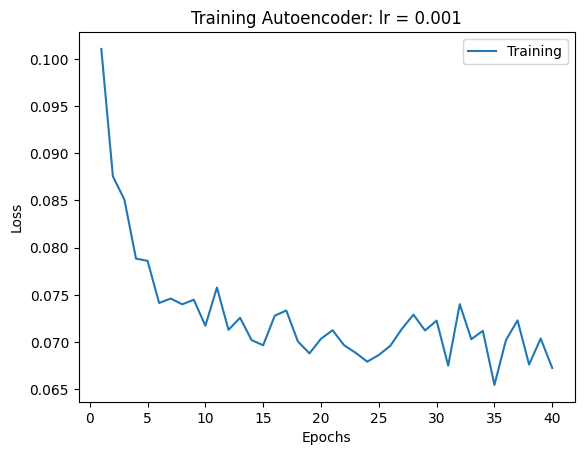

In [ ]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 40

ep = []
l = []

'''MNIST: 6m22s-7m38s'''
print("MNIST")
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    # save data (after the epoch is complete - last batch registered)
    ep.append(epoch+1)
    l.append(loss.item())
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Remember that we can see how the loss are changing along the epochs
import matplotlib.pyplot as plt

plt.plot(ep, l)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Autoencoder: lr = 0.001')
plt.legend(['Training'])
plt.show()

> Nota-se que com o *learning rate* de 0.001 e a dada configuração do modelo, a função de perda oscila ao invés de convergir para um valor conforme passam as epochs.

Treinando o modelo com *learning rate* de 0.0005:
* Lembrando de reiniciar o modelo!

In [ ]:
# Initialize the autoencoder
model = Autoencoder()

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the autoencoder
num_epochs = 40

ep = []
l = []

'''MNIST: 6m22s'''
print("MNIST")
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    # save data (after the epoch is complete - last batch registered)
    ep.append(epoch+1)
    l.append(loss.item())
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

cuda
MNIST
Epoch [1/50], Loss: 0.1099
Epoch [6/50], Loss: 0.0778
Epoch [11/50], Loss: 0.0720
Epoch [16/50], Loss: 0.0716
Epoch [21/50], Loss: 0.0701
Epoch [26/50], Loss: 0.0681
Epoch [31/50], Loss: 0.0708
Epoch [36/50], Loss: 0.0656
Epoch [41/50], Loss: 0.0692
Epoch [46/50], Loss: 0.0679


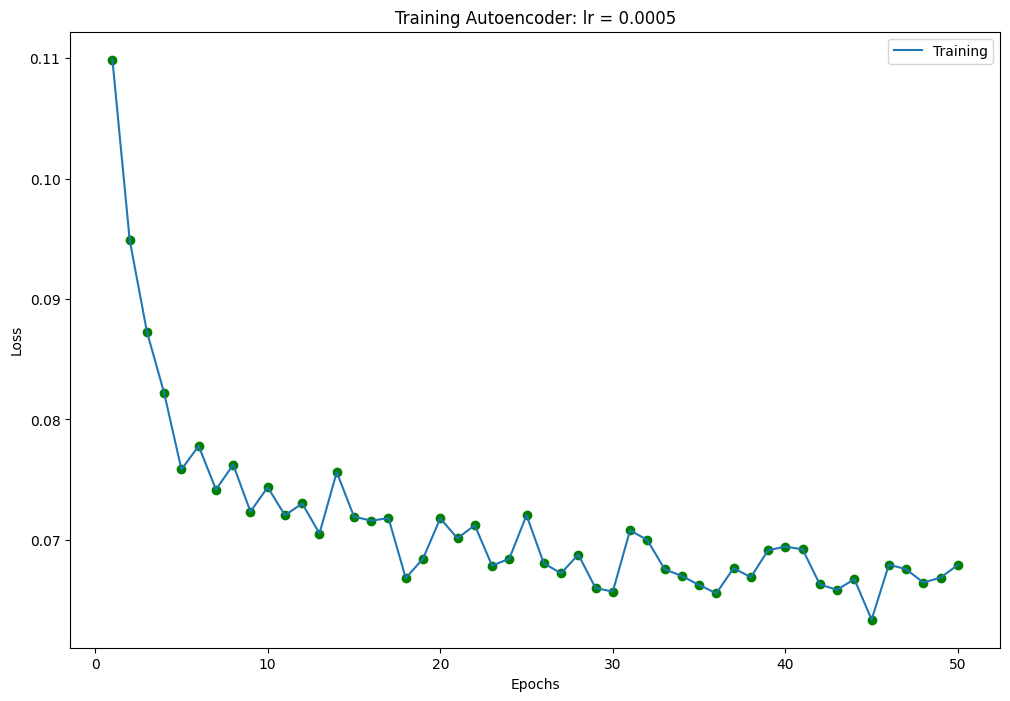

In [ ]:
# Remember that we can see how the loss are changing along the epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(ep, l)
plt.scatter(ep, l, color='g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0, 0.1])
plt.title('Training Autoencoder: lr = 0.0005')
plt.legend(['Training'])
plt.show()

> Por alguma razão o modelo não está convergindo para um valor de perda... (?)
* No gráfico acima temos a evolução da loss de apenas um batch, mais especificamente, do último batch. Para um batch específico temos flutuações.

Registrando a loss do treinamento referente à média de todos os batches após cada epoch, temos uma curva monotônica decrescente (como esperado, ou seja, o modelo está apredendo):

In [ ]:
# Loss(epoch): mean over all batches

# Initialize the autoencoder
model = Autoencoder()

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the autoencoder
num_epochs = 40

EP = []
L = []

'''MNIST: 6m22s'''
print("MNIST")
for epoch in range(num_epochs):
    ep = []
    l = []
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        # save data
        ep.append(epoch+1)
        l.append(loss.item())
    # save mean loss over all batches
    L.append(sum(l)/len(l))
    EP.append(epoch)
    if epoch % 5== 0: # print loss of the last batch of the epoch
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

cuda
MNIST
Epoch [1/40], Loss: 0.1150
Epoch [6/40], Loss: 0.0803
Epoch [11/40], Loss: 0.0764
Epoch [16/40], Loss: 0.0754
Epoch [21/40], Loss: 0.0698
Epoch [26/40], Loss: 0.0729
Epoch [31/40], Loss: 0.0690
Epoch [36/40], Loss: 0.0705


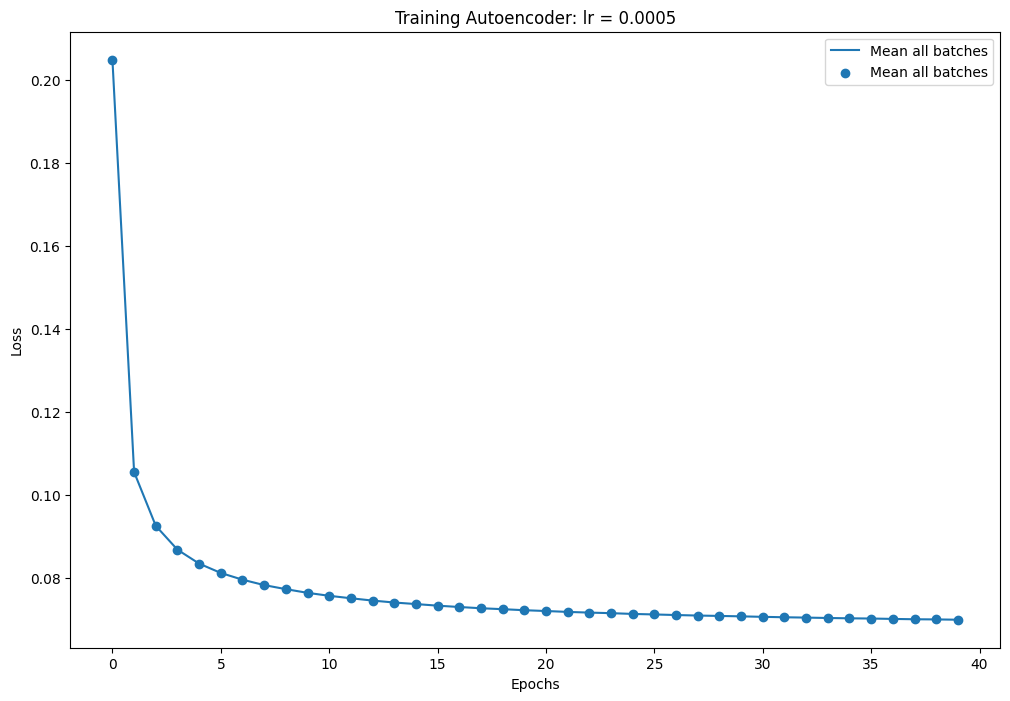

In [ ]:
# Remember that we can see how the loss are changing along the epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(EP, L)               # mean over all batches
plt.scatter(EP, L)
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0, 0.1])
plt.title('Training Autoencoder: lr = 0.0005')
plt.legend(['Mean all batches', 'Mean all batches'])
plt.show()

## Visualizing the results

In [ ]:
# Adding noise to images
def add_noise(x, stddev=0.2):
    noise = torch.randn(x.size()) * stddev
    if x.is_cuda:
        noise = noise.to(device)
    noisy_x = x + noise
    return torch.clamp(noisy_x, 0, 1)

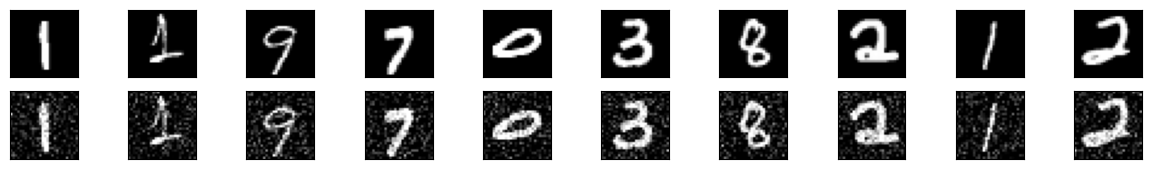

In [ ]:
# Visualizing original samples and samples with Gaussian noise
dataiter = iter(train_loader)
imgs, _ = next(dataiter)
noisy_imgs = add_noise(imgs)

n = 10
plt.figure(figsize=(15, 3))
for i in range(n):

    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Autoencoder: it was trained to encode and decode images. It supposedly can receive a noisy image and reconstruct it without (or with less) noise.

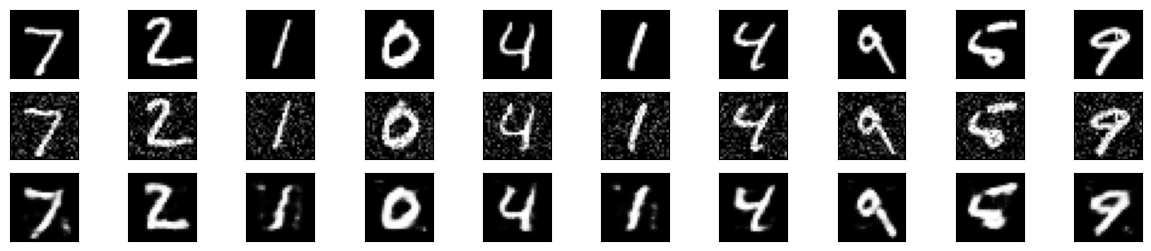

In [ ]:
dataiter = iter(test_loader)
imgs, _ = next(dataiter)
imgs = imgs.cuda()
noisy_imgs = add_noise(imgs) # noise added to testing set


# Denoise the noisy images
denoised_imgs = model(noisy_imgs)

imgs = imgs.to(torch.device('cpu'))
noisy_imgs = noisy_imgs.to(torch.device('cpu'))
denoised_imgs = denoised_imgs.to(torch.device('cpu'))

# Visualize original, noisy, and denoised images
n = 10
plt.figure(figsize=(15, 3))
for i in range(n):

    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_imgs[i].detach().squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

> We can see the model was successful in the task of reconstructing an image with less noise.

## Experimenting with different noise levels

**Run an experiment, training 5 denoising autoencoders**

Each model will be trained with images using different noise levels, parametrized by the following standard deviation values: 0.1, 0.2, 0.3, 0.4 and 0.5. Use 25 epochs for training.

After training:
1. On a single plot, show the curves of the loss functions evaluated on the training set for the 5 models.
2. Compare the 5 models, by:
  1. evaluating the average loss function value on the test set,
  2. showing images reconstructed by the 5 models

> Now the training_data has noise (no more the original images: MNIST + gaussian noise).

> The architecture of the autoencoder remains the same. The difference is the data it is going to receive in order to train (and therefore, learning).

In [ ]:
stddev = [0.1, 0.2, 0.3, 0.4, 0.5]

plt.figure(figsize=(12,8))

LOSS = []

for stdd in stddev:
  # Training dataset: adding noise
  dataiter = iter(train_loader)
  imgs, _ = next(dataiter)
  noisy_imgs = add_noise(imgs, stdd)

  # Initialize the autoencoder
  model = Autoencoder()

  # Move the model to GPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #print(device)
  model.to(device)

  # Define the loss function and optimizer
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0005)

  # Train the autoencoder
  num_epochs = 25

  # Loss(epoch): mean over all batches

  EP = []
  L = []

  '''MNIST: 6m22s'''
  print("MNIST: stddev = ", stdd)
  for epoch in range(num_epochs):
      ep = []
      l = []
      for data in train_loader:
          img, _ = data
          img = img.to(device)
          optimizer.zero_grad()
          output = model(img)
          loss = criterion(output, img)
          loss.backward()
          optimizer.step()
          # save data
          ep.append(epoch+1)
          l.append(loss.item())
      # save mean loss over all batches
      L.append(sum(l)/len(l))
      EP.append(epoch)

  # plot loss for the model given an stddev
  plt.plot(EP, L, label=('stddev = ' + str(i)))
  plt.scatter(EP, L)

  # save losses for the model given an stddev
  LOSS.append(L)

plt.title('Training Autoencoder with noise images')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

MNIST: stddev =  0.1


In [ ]:
def abc(d, e=2):
  return d + e
print(abc(1))
print(abc(1, 100))

3
101


[]
[[1, 2, 3, 4, 5], [2, 4, 6, 8, 10], [3, 6, 9, 12, 15]]


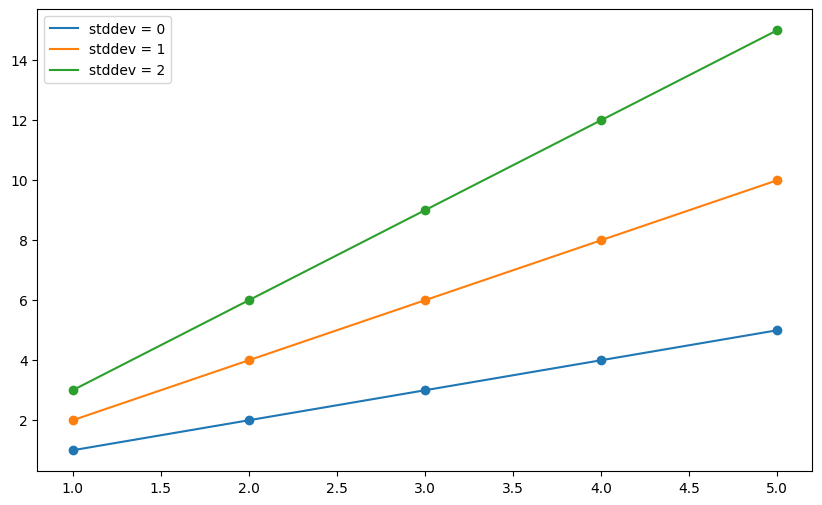

In [ ]:
h = [1, 2, 3, 4, 5]
y = [[1, 2, 3, 4, 5], [2, 4, 6, 8, 10], [3, 6, 9, 12, 15]]
a = []
print(a)

plt.figure(figsize=(10, 6))
for i in range(3):
  plt.plot(h, y[i], label=('stddev = ' + str(i)))
  plt.scatter(h, y[i])
  a.append(y[i])
print(a)
plt.legend()
plt.show()

Links:
* https://www.geeksforgeeks.org/implement-convolutional-autoencoder-in-pytorch-with-cuda/
* https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html
* https://discuss.pytorch.org/t/how-to-convert-to-linear/93315